# Estimating US Equities Earnings Yield with Macro Factors

In [7]:
import pandas as pd
import numpy as np
import pandas_datareader.data as pdr

import statsmodels.api as sm
import statsmodels.formula.api as smf

import math

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#### Getting the Data

Let's get our data. Earnings and S&P Composite data come from Robert Shiller's website, http://www.econ.yale.edu/~shiller/data. The explanatory variable candidates we can get from https://fred.stlouisfed.org/, which is an economic database hosted kindly by the St. Louis Federal Reserve Bank.

In [8]:
start_date = "1962-01-01"
end_date = "10-31-2023"

DGS1_Data = pdr.get_data_fred("DGS1", start = start_date, end = end_date) #  Market Yield on U.S. Treasury Securities at 1-Year Constant Maturity, Quoted on an Investment Basis (DGS1)
DGS10_Data = pdr.get_data_fred("DGS10", start = start_date, end = end_date) # Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (DGS10)
CPIAUCSL_Data = pdr.get_data_fred("CPIAUCSL", start = start_date, end = end_date) # Consumer Price Index for All Urban Consumers: All Items in U.S. City Average  (CPIAUCSL)
M2_Data = pdr.get_data_fred("M2SL", start = start_date, end = end_date) # Monetary Base --> M2 (M2SL)
M1_Data = pdr.get_data_fred("M1SL", start = start_date, end = end_date) # Monetary Base --> M1 (M1SL)
UNRATE_Data = pdr.get_data_fred("UNRATE", start = start_date, end = end_date) # Unemployment Rate (UNRATE)
FEDG_EXP_Data = pdr.get_data_fred("W019RCQ027SBEA", start = start_date, end = end_date) # Federal government total expenditures (W019RCQ027SBEA)
FEDG_REV_Data = pdr.get_data_fred("W018RC1Q027SBEA", start = start_date, end = end_date) # Federal government total receipts (W018RC1Q027SBEA)
WTISPLC_Data = pdr.get_data_fred("WTISPLC", start = start_date, end = end_date) # Spot Crude Oil Price: West Texas Intermediate (WTI) (WTISPLC)
LOANINV_Data = pdr.get_data_fred("LOANINV", start = start_date, end = end_date) # Bank Credit, All Commercial Banks (LOANINV)
PPIACO_Data = pdr.get_data_fred("PPIACO", start = start_date, end = end_date) # Producer Price Index by Commodity: All Commodities (PPIACO)

WILL5000PR_Data = pdr.get_data_fred("WILL5000PR", start = start_date, end = end_date) # Wilshire 5000 Price Index (WILL5000PR)


In [9]:
url_rs = "http://www.econ.yale.edu/~shiller/data/ie_data.xls"
Shiller_Data = pd.read_excel(url_rs,  sheet_name="Data", parse_dates=True, skiprows=7, index_col = 0, usecols = "A:D")

C:\Users\george.georgiev\AppData\Local\Temp\ipykernel_12968\1837844182.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Shiller_Data = pd.read_excel(url_rs,  sheet_name="Data", parse_dates=True, skiprows=7, index_col = 0, usecols = "A:D")


#### Examining and cleaning the raw data

Let's look at Robert Shiller’s data.

In [10]:
Shiller_Data

,P,D,E
Date,,,
1871-01-01,4.44,0.26,0.40
1871-02-01,4.5,0.26,0.40
1871-03-01,4.61,0.26,0.40
1871-04-01,4.74,0.26,0.40
1871-05-01,4.86,0.26,0.40
...,...,...,...
2023-06-01,4345.372857,68.71,181.17
2023-07-01,4508.0755,NaN,NaN
2023-08-01,4457.358696,NaN,NaN


In [11]:
Shiller_Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1834 entries, 1871-01-01 to NaT
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   P       1834 non-null   object 
 1   D       1830 non-null   float64
 2   E       1830 non-null   float64
dtypes: float64(2), object(1)
memory usage: 57.3+ KB


Not all the data is numeric in the P column, so we clean that up and drop rows where we have NAs.

In [12]:
SR_Data = Shiller_Data.apply(pd.to_numeric, errors = "coerce").dropna()

The S&P price and earnings data provided by Robert Shiller uses the mean monthly price. To match the Federal Reserve data, we will convert it to the end of the prior month. We also need to create a new column for the earnings yield.

In [13]:
start = SR_Data.index.dropna()[0] - pd.offsets.MonthEnd(0)
end = SR_Data.index.dropna()[-1] - pd.offsets.MonthEnd(0)
datetime_index = pd.date_range(start=start, end=end, freq='ME')
SR_Data.index = datetime_index

SR_Data["SPEY"] = SR_Data["E"] / SR_Data["P"]

C:\Users\george.georgiev\AppData\Local\Temp\ipykernel_12968\2123345131.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  datetime_index = pd.date_range(start=start, end=end, freq='M')


Let's plot the price and earnings data.

Correlations Table: 
           P         E
P  1.000000  0.973778
E  0.973778  1.000000


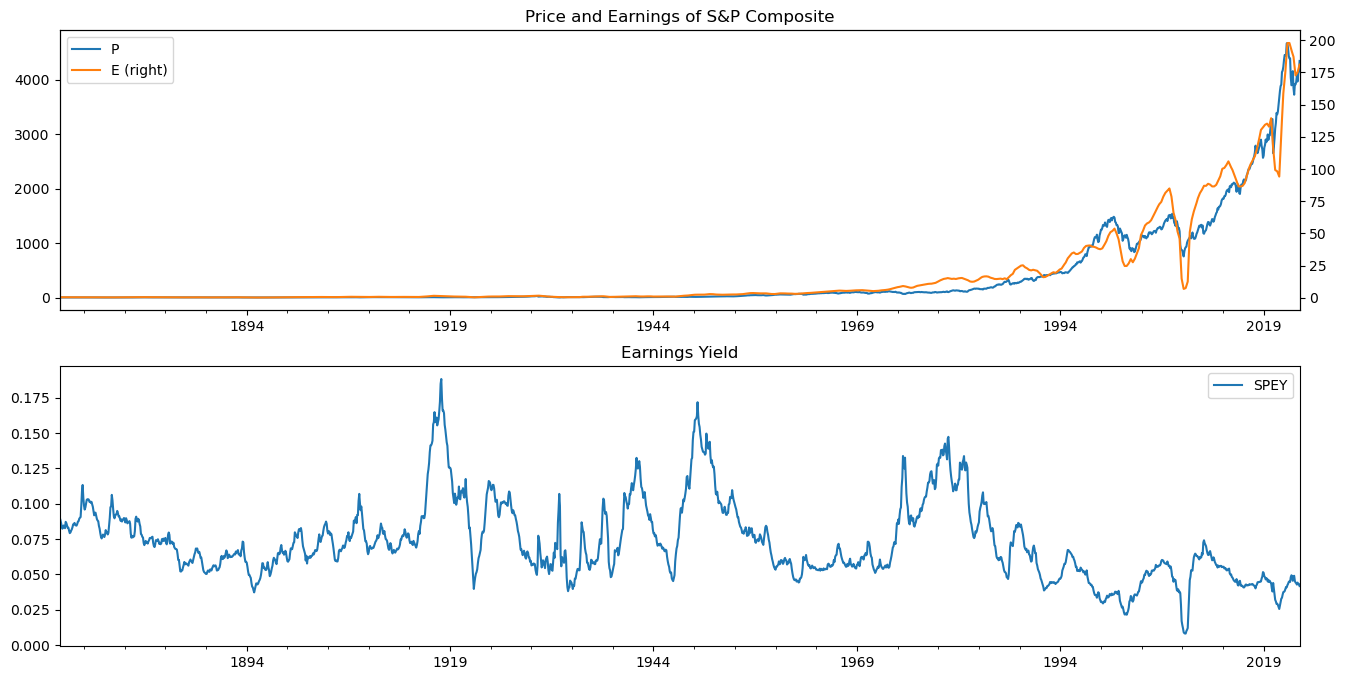

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

SR_Data[["P", "E"]].plot(ax = ax[0], secondary_y = "E", title = "Price and Earnings of S&P Composite")
SR_Data[["SPEY"]].plot(ax = ax[1], title = "Earnings Yield")

print("Correlations Table: \n" , SR_Data[["P", "E"]].corr())

As expected, earnings and prices track each other closely and are almost perfectly correlated. Earning yield has fluctuated quite a lot throughout history. Now, let’s load and clean up our explanatory variable candidates. Most of the data is monthly, but we will need to convert a couple of quarterly datasets to monthly.

The 10- and 1-year US Treasury Yields will be divided by 100, converted to decimal form, and interpolated linearly to fill up missing data. Federal Revenue and Expenditures are quarterly data, so we must convert them to monthly and interpolate to fill in missing data. We also make sure that end-of-month data is used.

In [32]:
DGS1_M = DGS1_Data.resample("ME").last().interpolate()/100
DGS10_M = DGS10_Data.resample("ME").last().interpolate()/100

FEDG_EXP_Q = FEDG_EXP_Data.resample("QE").last().rename(columns={"W019RCQ027SBEA":"FEDG_EXP"})
FEDG_REV_Q = FEDG_REV_Data.resample("QE").last().rename(columns={"W018RC1Q027SBEA":"FEDG_REV"})
FEDG_EXP_M = FEDG_EXP_Q.resample("ME").last().interpolate()
FEDG_REV_M = FEDG_REV_Q.resample("ME").last().interpolate()

CPIAUCSL_M = CPIAUCSL_Data.resample("ME").last()
M2_M = M2_Data.resample("ME").last()
M1_M = M1_Data.resample("ME").last()
UNRATE_M = UNRATE_Data.resample("ME").last()
WTISPLC_M = WTISPLC_Data.resample("ME").last()
PPIACO_M = PPIACO_Data.resample("ME").last()
LOANINV_M = LOANINV_Data.resample("ME").last()

FRED_M = pd.concat([DGS1_M, DGS10_M, FEDG_EXP_M, FEDG_REV_M, CPIAUCSL_M, M2_M, M1_M, UNRATE_M, WTISPLC_M, PPIACO_M, LOANINV_M], axis = 1)

The few variables missing from the most recent month's data will be filled with the prior month’s value.

In [34]:
FRED_M = FRED_M.ffill().dropna()
FRED_M

,DGS1,DGS10,FEDG_EXP,FEDG_REV,CPIAUCSL,M2SL,M1SL,UNRATE,WTISPLC,PPIACO,LOANINV
DATE,,,,,,,,,,,
1962-03-31,0.0297,0.0386,118.949000,102.434000,30.170,343.1,146.0,5.6,2.97,31.700,215.2730
1962-04-30,0.0307,0.0386,119.545000,103.042667,30.210,345.5,146.4,5.6,2.97,31.600,217.3381
1962-05-31,0.0299,0.0390,120.141000,103.651333,30.240,347.5,146.8,5.5,2.97,31.500,218.3177
1962-06-30,0.0320,0.0400,120.737000,104.260000,30.210,349.3,146.6,5.5,2.97,31.500,220.3377
1962-07-31,0.0333,0.0404,121.257667,105.005333,30.220,350.8,146.5,5.4,2.97,31.600,221.4149
...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,0.0537,0.0409,6870.604000,4747.505333,306.187,20765.3,18271.6,3.8,81.39,257.680,17296.5100
2023-09-30,0.0546,0.0459,7031.405000,4765.448000,307.288,20710.9,18151.7,3.8,89.43,258.934,17291.2280
2023-10-31,0.0544,0.0488,6925.483333,4798.323667,307.531,20691.7,18070.1,3.8,85.64,255.192,17264.1757


Let's combine FRED_M and the SR_Data sets and drop the missing data. This dataset will contain data up to 6-30-2023. We will later use the most recent data to make predictions.

In [35]:
REG_DATA = pd.concat([SR_Data[["SPEY"]], FRED_M], axis = 1).dropna()

#### Explore the independent variable and potential model

Let's create a correlation table of the variables. 

In [36]:
REG_DATA.corr()

,SPEY,DGS1,DGS10,FEDG_EXP,FEDG_REV,CPIAUCSL,M2SL,M1SL,UNRATE,WTISPLC,PPIACO,LOANINV
SPEY,1.000000,0.745294,0.719130,-0.481898,-0.510165,-0.506423,-0.451779,-0.286449,0.310217,-0.205411,-0.406805,-0.485642
DGS1,0.745294,1.000000,0.946492,-0.647222,-0.634107,-0.606973,-0.617180,-0.346766,0.079148,-0.481035,-0.546653,-0.657031
DGS10,0.719130,0.946492,1.000000,-0.662186,-0.657818,-0.583167,-0.654712,-0.419693,0.279614,-0.449858,-0.519785,-0.689546
FEDG_EXP,-0.481898,-0.647222,-0.662186,1.000000,0.964391,0.936894,0.979162,0.772257,0.002656,0.776259,0.931287,0.982465
FEDG_REV,-0.510165,-0.634107,-0.657818,0.964391,1.000000,0.970913,0.968441,0.701541,-0.131210,0.792126,0.960050,0.984529
CPIAUCSL,-0.506423,-0.606973,-0.583167,0.936894,0.970913,1.000000,0.908812,0.594989,-0.005668,0.811593,0.987186,0.940540
M2SL,-0.451779,-0.617180,-0.654712,0.979162,0.968441,0.908812,1.000000,0.819256,-0.096114,0.746772,0.909708,0.989027
M1SL,-0.286449,-0.346766,-0.419693,0.772257,0.701541,0.594989,0.819256,1.000000,-0.123045,0.455918,0.619722,0.742395
UNRATE,0.310217,0.079148,0.279614,0.002656,-0.131210,-0.005668,-0.096114,-0.123045,1.000000,0.166133,0.052086,-0.090352
WTISPLC,-0.205411,-0.481035,-0.449858,0.776259,0.792126,0.811593,0.746772,0.455918,0.166133,1.000000,0.870319,0.791773


A lot of the variables exhibit high negative or positive correlation. However, correlations can lie. Let's plot the data.

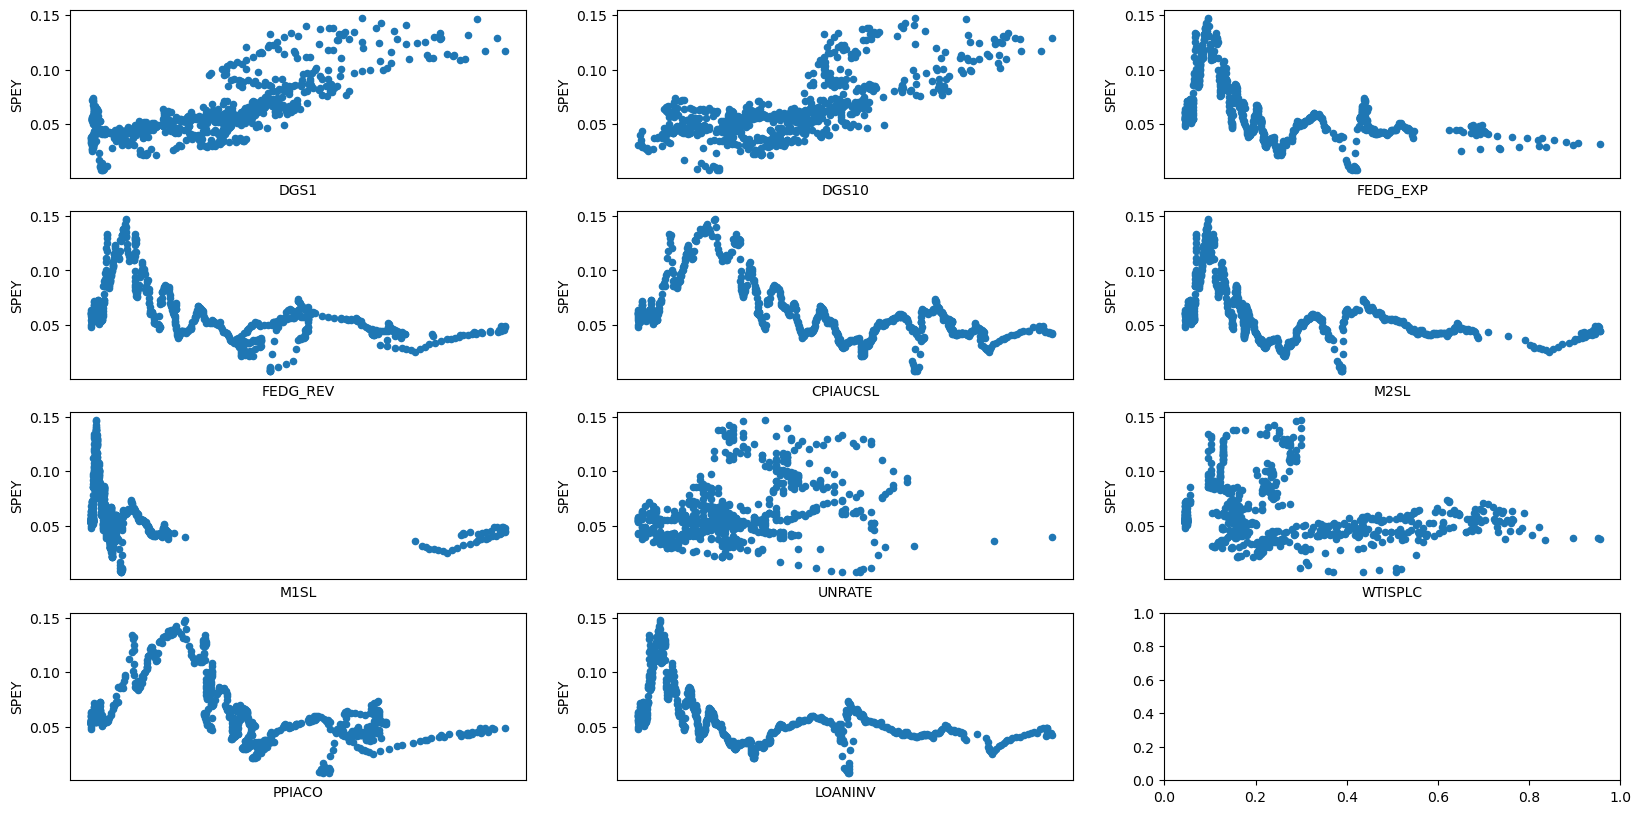

In [37]:
import math
n_cols = 3
n_rows = math.ceil(FRED_M.shape[1] / n_cols)

row_col = [(i,j) for i in range(n_rows) for j in range(n_cols)]
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 10))

for idx, col_name in enumerate(FRED_M):
    REG_DATA.plot.scatter(ax = ax[row_col[idx]], x=col_name, y="SPEY")
    ax[row_col[idx]].set_xticks([])

Besides DGS1 and DGS10 (US Treasury Yields), the other variables don’t seem to exhibit a relationship and appear to suffer from autocorrelation. In that case, we should do some feature engineering and covert so the percentage changes and ratios.

In [38]:
REG_DATA["CPI_PREM"] = REG_DATA["CPIAUCSL"] / REG_DATA["DGS10"] #CPI to 10Y Ratio
REG_DATA["FEDG_EXPtoRev"] = REG_DATA["FEDG_EXP"]/REG_DATA["FEDG_REV"].values # Federal Expenditures to Federal Revenue
REG_DATA["FEDG_NetEXP"] = REG_DATA["FEDG_EXP"] - REG_DATA["FEDG_REV"].values # Net Federal Expenditures (AKA: Federal Deficit)
REG_DATA["Curve_10MINUS1"] = REG_DATA["DGS10"] - REG_DATA["DGS1"] # Yield curve: 10-year minus 1-year
REG_DATA["Ratio_10to1"] = (REG_DATA["DGS10"] / REG_DATA["DGS1"]) # Ratio of 10-Year to 1-Year yields


REG_DATA["CPI_PCT"] = REG_DATA["CPIAUCSL"].pct_change(12) # 12 month percentage change CPI
REG_DATA["M2_PCT"] = REG_DATA["M2SL"].pct_change(12) # 12 month percentage change M2
REG_DATA["M1_PCT"] = REG_DATA["M1SL"].pct_change(12) # 12 month percentage change M1
REG_DATA["WTISPLC_PCT"] = REG_DATA["WTISPLC"].pct_change(12) # 12 month percentage change WTI (Oil Prices)
REG_DATA["PPIACO_PCT"] = REG_DATA["PPIACO"].pct_change(12) # 12 month percentage change Commodity Producers Index
REG_DATA["LOANINV_PCT"] = REG_DATA["LOANINV"].pct_change(12) # 12 month percentage change in Bank Loans
REG_DATA["FEDG_NetEXP_PCT"] = REG_DATA["FEDG_NetEXP"].pct_change(12) # 12 month percentage change in Federal Deficit
REG_DATA["UNRATE_PCT"] = REG_DATA["UNRATE"].pct_change(12) # 12 month percentage change Unemployment Rate

REG_DATA["FEDG_NetEXP_DIFF"] = REG_DATA["Ratio_10to1"].pct_change(24)
REG_DATA["Inversion_10to1"] = (REG_DATA["Curve_10MINUS1"] < 0).astype("int") # binary: 1 of yield curve inverted 0 for not inversion

Let's plot the data with some of the new variables/features.

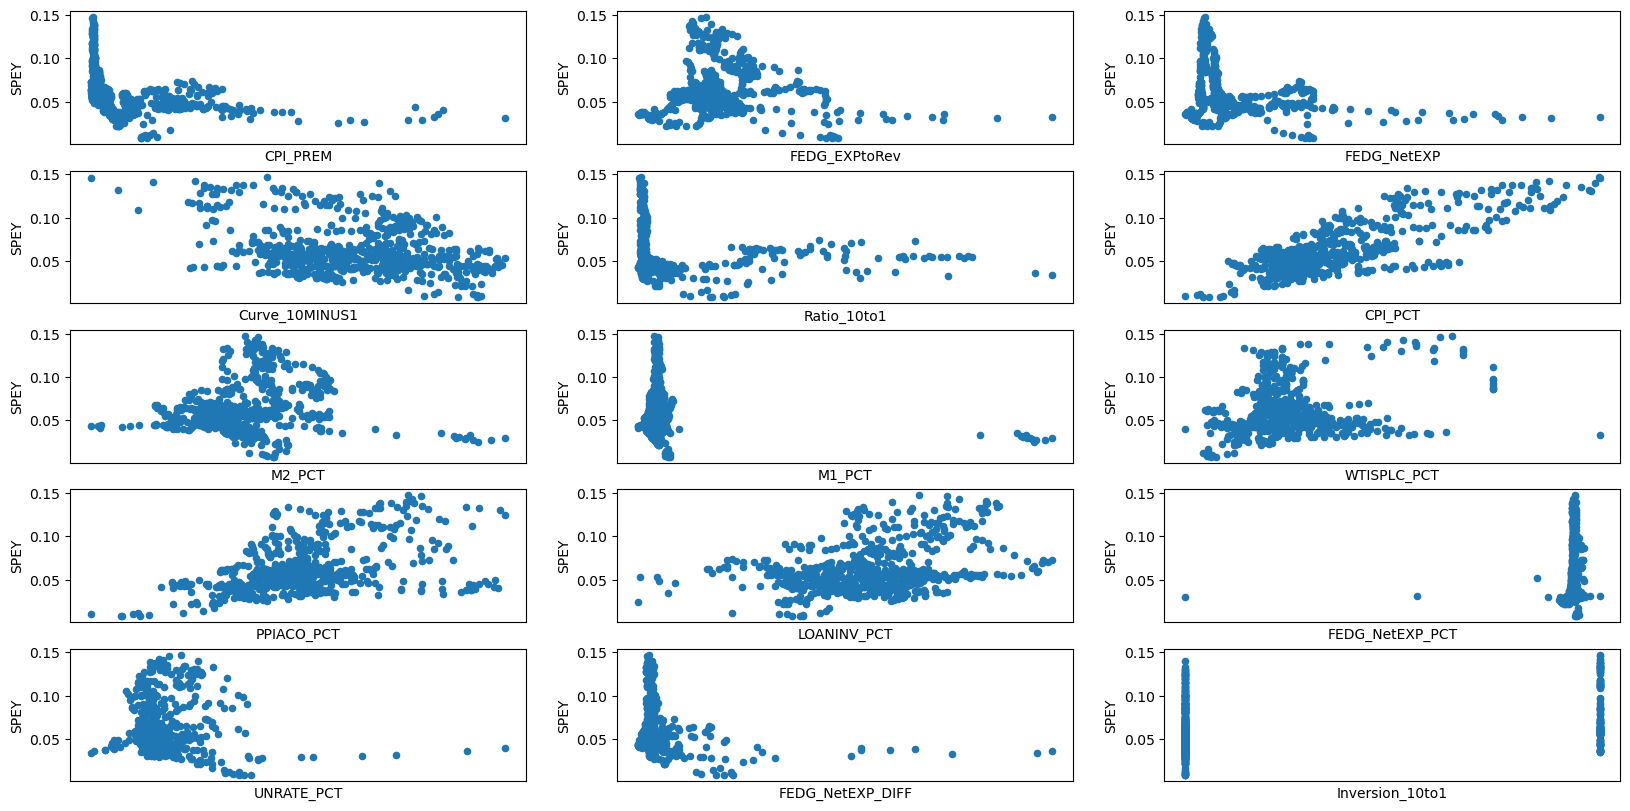

In [39]:
plot_cols = ["CPI_PREM", "FEDG_EXPtoRev", "FEDG_NetEXP", "Curve_10MINUS1", "Ratio_10to1", "CPI_PCT", "M2_PCT", "M1_PCT", "WTISPLC_PCT", "PPIACO_PCT", "LOANINV_PCT", "FEDG_NetEXP_PCT", "UNRATE_PCT", "FEDG_NetEXP_DIFF", "Inversion_10to1"]

n_cols = 3
n_rows = math.ceil(len(plot_cols) / n_cols)

row_col = [(i,j) for i in range(n_rows) for j in range(n_cols)]
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 10))

for idx, col_name in enumerate(plot_cols):
    REG_DATA.plot.scatter(ax = ax[row_col[idx]], x=col_name, y="SPEY")
    ax[row_col[idx]].set_xticks([])


Besides DGS1 and DGS10 from the prior plot, we can spot a few potentially useful explanatory variables:  Curve_10MINUS1, CPI_PCT, PPIACO_PCT, and LOANINV_PCT. Let's examine whether some of these variables are correlated, as including them will increase multicollinearity in our regression.

In [40]:
REG_DATA[["SPEY", "DGS1", "DGS10", "Curve_10MINUS1", "CPI_PCT", "PPIACO_PCT", "LOANINV_PCT"]].corr()

,SPEY,DGS1,DGS10,Curve_10MINUS1,CPI_PCT,PPIACO_PCT,LOANINV_PCT
SPEY,1.000000,0.745294,0.719130,-0.352634,0.772621,0.445281,0.340900
DGS1,0.745294,1.000000,0.946492,-0.521792,0.677871,0.265318,0.424428
DGS10,0.719130,0.946492,1.000000,-0.218561,0.599487,0.187875,0.298800
Curve_10MINUS1,-0.352634,-0.521792,-0.218561,1.000000,-0.465804,-0.305502,-0.493298
CPI_PCT,0.772621,0.677871,0.599487,-0.465804,1.000000,0.744121,0.323065
PPIACO_PCT,0.445281,0.265318,0.187875,-0.305502,0.744121,1.000000,0.281758
LOANINV_PCT,0.340900,0.424428,0.298800,-0.493298,0.323065,0.281758,1.000000


We can eliminate a few of the explanatory variables:
- DGS1 and DGS10 are highly correlated; we will use only DGS10
- PPIACO_PCT and CPI_PCT are highly correlated; we will use only CPI_PCT

Let's look at the regression results for the variables we have selected.


In [41]:
formula = "SPEY ~ DGS10 + Curve_10MINUS1 + CPI_PCT + LOANINV_PCT"
results = smf.ols(formula, data=REG_DATA).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   SPEY   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     425.3
Date:                Wed, 29 May 2024   Prob (F-statistic):          8.16e-188
Time:                        13:33:16   Log-Likelihood:                 2034.5
No. Observations:                 724   AIC:                            -4059.
Df Residuals:                     719   BIC:                            -4036.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0186      0.002      9.

"Curve_10MINUS1" doesn't add much value as it has a very high p-value. In that case, it will be removed.

The final model will be like this:


In [42]:
formula = "SPEY ~ DGS10 + CPI_PCT + LOANINV_PCT"
results = smf.ols(formula, data=REG_DATA).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   SPEY   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     567.8
Date:                Wed, 29 May 2024   Prob (F-statistic):          3.20e-189
Time:                        13:33:19   Log-Likelihood:                 2034.5
No. Observations:                 724   AIC:                            -4061.
Df Residuals:                     720   BIC:                            -4043.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0189      0.002     12.388      

The regression model has an Adjusted R^2 of 0.702, meaning that these variables explain 70% of the variation in "SPEY". However, we can also see that the model is not perfect:
- It suffers from autocorrelation --> Durbin-Watson is below 2 --> 0.047
- The errors are not normally distributed as Jarque-Bera (JB) is well above 0 --> 18.988

Let's look at the individual independent variables and see how each relates to what we try to predict "SPEY."

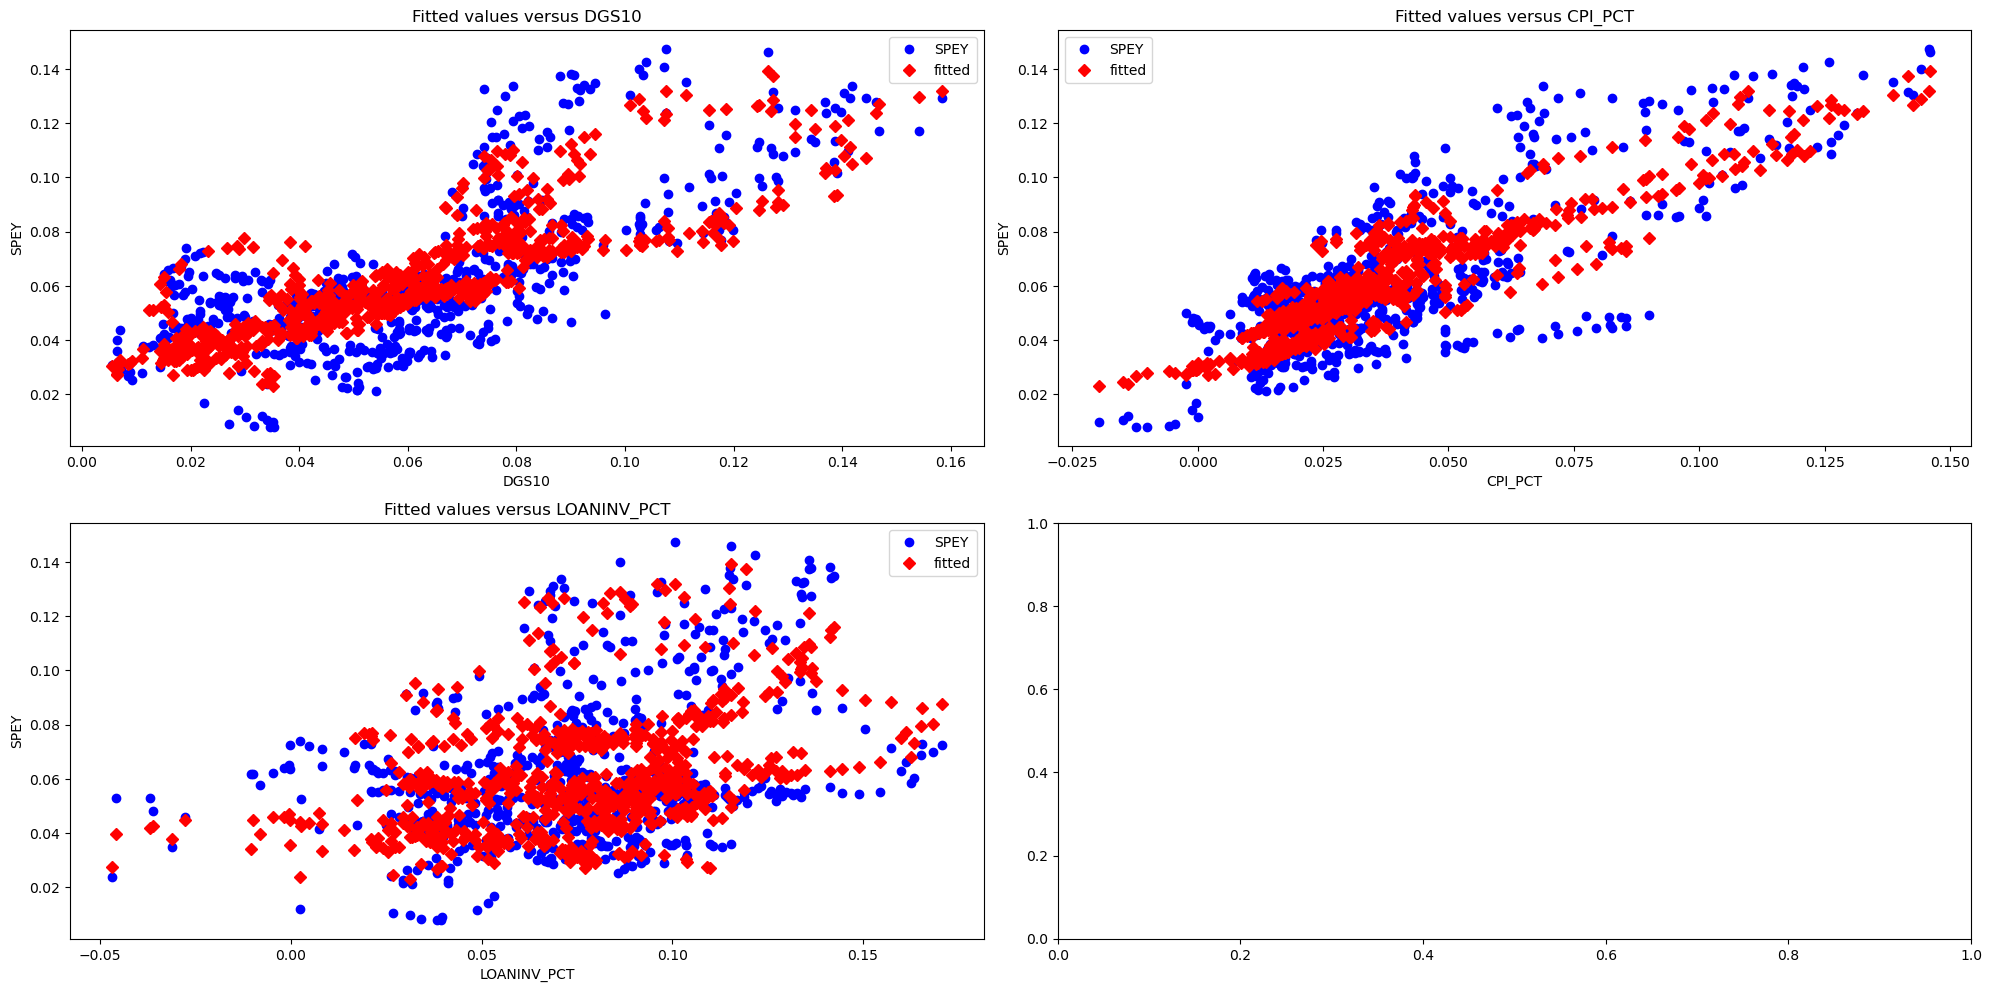

In [43]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

sm.graphics.plot_fit(results, "DGS10", ax = ax[0,0], vlines =  False)
sm.graphics.plot_fit(results, "CPI_PCT", ax = ax[0,1], vlines =  False)
sm.graphics.plot_fit(results, "LOANINV_PCT", ax = ax[1,0], vlines =  False)
fig.tight_layout(pad=1.0)

The fitted values look very similar to the actual values, telling us that regression is doing a good job. We can test the model's effectiveness in many other ways, like running cross-validation. However, this is different from my goal here. I want to know how closely the model tracks the actual earnings yield and whether deviations from the model represent over/undervalued markets. An overvalued market will be where the actual earnings yield is well below the predicted earnings yield. If the earning yields need to move higher, then prices might decline. The inverse is true for undervalued markets; predicted earnings yield below actual earnings yield could signal that prices need to appreciate. 

Let's test this by creating a new data table that contains predicted, actual, and forecasted price appreciation/depreciation. We will start from 1971, which means that the first model will be regressed on data from 1962 to 1971, and the subsequent regression will include the next additional month, along with all data since 1962. A data table will save the calculated actual and predicted earnings yields.



In [44]:
pred_ey_dict = {}
actual_ey_dict = {}

for date in REG_DATA["1971":].index:

    data = REG_DATA[:date]

    formula = "SPEY ~ DGS10 + CPI_PCT + LOANINV_PCT"
    results = smf.ols(formula, data=data).fit()

    # The last values of the test period
    Y10 = data["DGS10"].iloc[-1]
    CPI_PCT = data["CPI_PCT"].iloc[-1]
    LOANINV_PCT = data["LOANINV_PCT"].iloc[-1]

    pred_dict = {"DGS10": Y10, "CPI_PCT":CPI_PCT, "LOANINV_PCT": LOANINV_PCT}
    X = pd.DataFrame(pred_dict, index = ["Pred"])

    predicted_ey = results.predict(X).values[0]
    actual_ey = data["SPEY"].iloc[-1] 

    pred_ey_dict[date] = predicted_ey
    actual_ey_dict[date] = actual_ey

forecast_df = pd.DataFrame.from_dict({"Pred_EY": pred_ey_dict, "Actual_EY":actual_ey_dict})

Let's add a new column representing the Wilshire 5000 Price Index movements.

In [46]:
W5000PR = WILL5000PR_Data.resample("ME").last()
W5000PR["W5000PR_PCT"] = W5000PR.pct_change()
fcast_df = pd.concat([forecast_df, W5000PR], axis =1).dropna()

Next, let's plot the predicted and actual earnings yield.

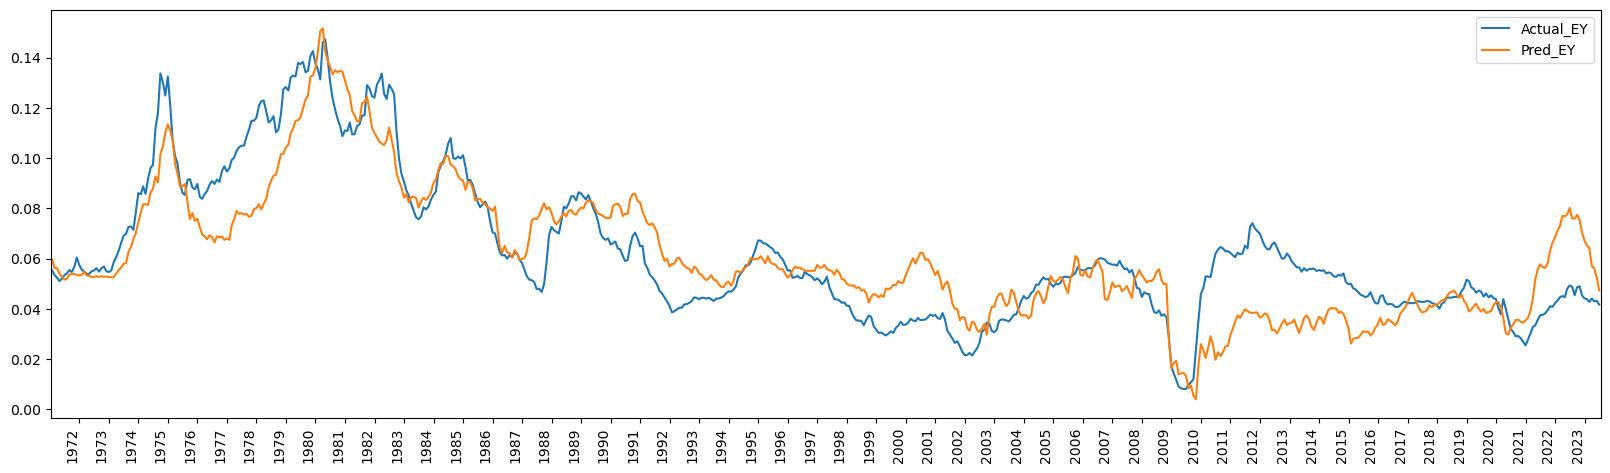

In [47]:
fcast_df.loc["1971":"2023", ["Actual_EY", "Pred_EY"]].plot(figsize = (20,6), x_compat=True)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.margins(x=0.001, y=0.05)

plt.xticks(rotation=90)
plt.show()

The actual and predicted earnings yields track each other decently well, with a few exceptions.
- Around 1977 actual_ey > pred_ey (undervalued)
- Around 1988 actual_ey < pred_ey (overvalued)
- Around 1992 actual_ey < pred_ey (overvalued)
- Around 2000 actual_ey < pred_ey (overvalued)
- Around 2010 actual_ey > pred_ey (undervalued)
- Around 2022 actual_ey < pred_ey (undervalued)

Let's plot around those periods and observe the Wilshire 5000 Price Index movements.

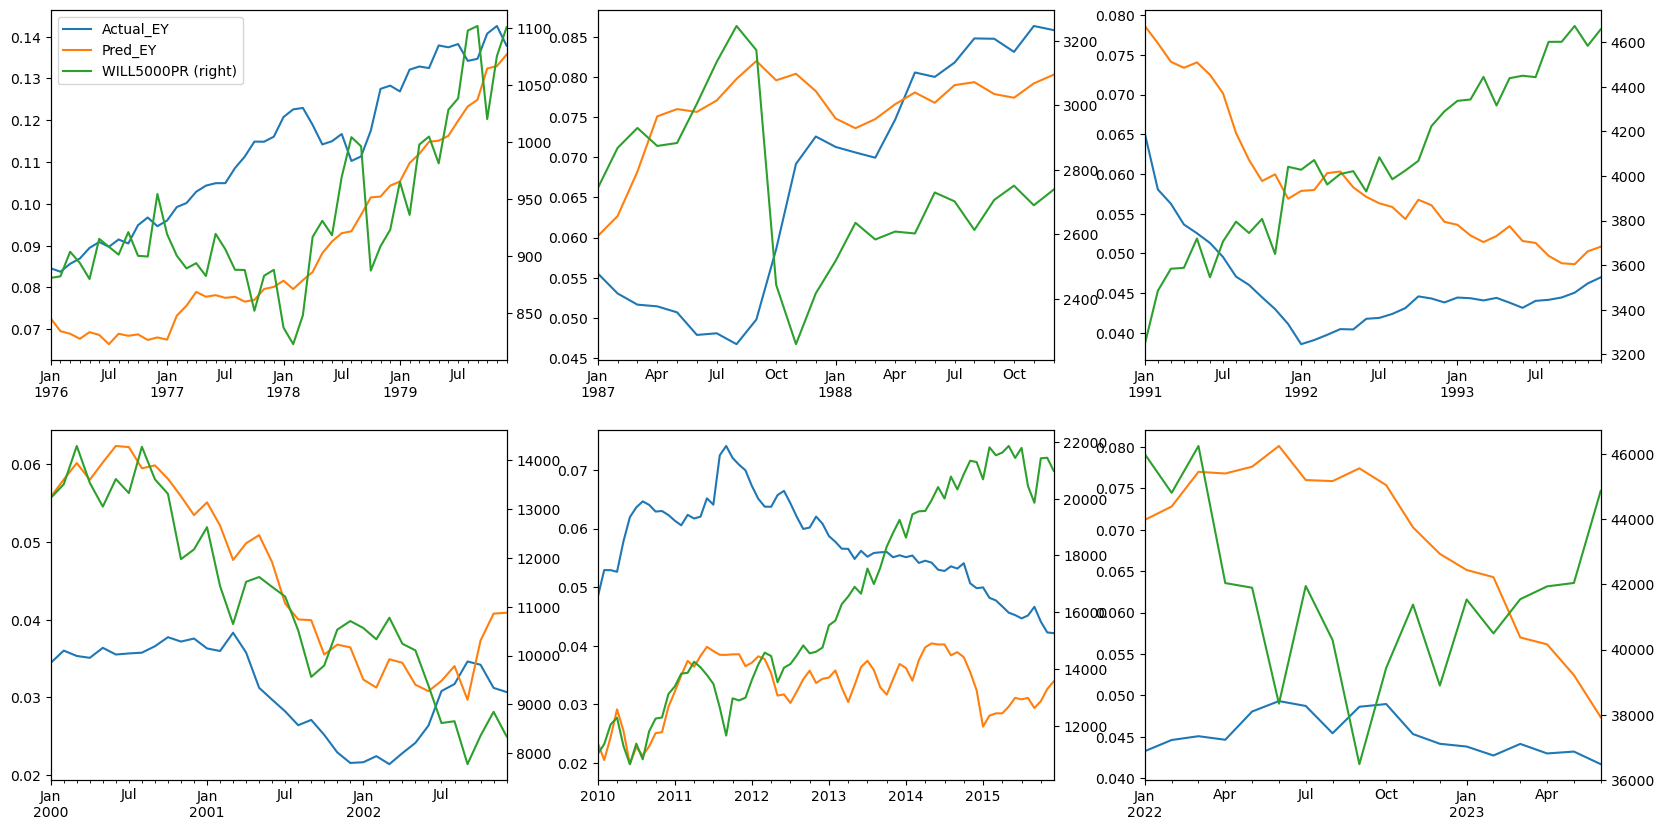

In [49]:
fig, ax = plt.subplots(nrows = 2, ncols =3, figsize=(20, 10))
fcast_df.loc["1976":"1979", ["Actual_EY", "Pred_EY", "WILL5000PR"]].plot(ax = ax[0,0], secondary_y = "WILL5000PR")
fcast_df.loc["1987":"1988", ["Actual_EY", "Pred_EY", "WILL5000PR"]].plot(ax = ax[0,1], secondary_y = "WILL5000PR", legend = False)
fcast_df.loc["1991":"1993", ["Actual_EY", "Pred_EY", "WILL5000PR"]].plot(ax = ax[0,2], secondary_y = "WILL5000PR", legend = False)
fcast_df.loc["2000":"2002", ["Actual_EY", "Pred_EY", "WILL5000PR"]].plot(ax = ax[1,0], secondary_y = "WILL5000PR", legend = False)
fcast_df.loc["2010":"2015", ["Actual_EY", "Pred_EY", "WILL5000PR"]].plot(ax = ax[1,1], secondary_y = "WILL5000PR", legend = False)
fcast_df.loc["2022":, ["Actual_EY", "Pred_EY", "WILL5000PR"]].plot(ax = ax[1,2], secondary_y = "WILL5000PR", legend = False)

# Change the font size of all labels and titles
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Judging from those six periods, only the 1991-1993 period is a false signal, as the market continued to move higher, despite the model signaling that the market is overvalued. This is not bad; that's 5/6 times the model was useful. The model did fail to provide a signal in late 2007 about the impending Great Financial Crisis. Let's calculate the average returns when the actual earnings yield is higher or lower than predicted.

In [50]:
aey_pey_mean_ret = fcast_df.loc[(fcast_df["Actual_EY"] > fcast_df["Pred_EY"]), "W5000PR_PCT"].mean()
pey_aey_mean_ret = fcast_df.loc[(fcast_df["Actual_EY"] < fcast_df["Pred_EY"]), "W5000PR_PCT"].mean()
print("Average monthly return when actual earnings yield is higher than predicted earnings yield: ",round(aey_pey_mean_ret, 5))
print("Average monthly return when actual earnings yield is lower than predicted earnings yield: ", round(pey_aey_mean_ret, 5))

Average monthly return when actual earnings yield is higher than predicted earnings yield:  0.00875
Average monthly return when actual earnings yield is lower than predicted earnings yield:  0.00597


Average monthly returns tend to be higher when the actual earnings yield is higher than the predicted yield (the market is undervalued). As they say, "Good enough for public work".